# Record Linkage Example

## Boilerplate

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from importlib import reload
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

In [3]:
import sys

sys.path.insert(0, '..')

In [4]:
import entity_embed  # force n2 import to avoid libgomp issue https://github.com/kakao/n2/issues/42

In [5]:
import torch
import numpy as np

random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

## Load Dataset

We'll use the [Amazon-GoogleProducts](https://dbs.uni-leipzig.de/research/projects/object_matching/benchmark_datasets_for_entity_resolution). The dataset is stored in a ZIP file with 3 CSV files: Two are the entity source files, the third one is the perfect mapping.

Let's download the ZIP:

In [6]:
import urllib
import tempfile

dataset_url = 'https://dbs.uni-leipzig.de/file/Amazon-GoogleProducts.zip'
tf = tempfile.NamedTemporaryFile(mode='r', delete=False)
tf.close()

urllib.request.urlretrieve(dataset_url, tf.name);

Extracting the files:

In [7]:
import zipfile
import os

td = tempfile.TemporaryDirectory()

with zipfile.ZipFile(tf.name, "r") as zf:
    zf.extractall(td.name)

os.listdir(td.name)

['Amazon.csv', 'GoogleProducts.csv', 'Amzon_GoogleProducts_perfectMapping.csv']

Now we must read the **two** CSV files `'Amazon.csv'` and `'GoogleProducts.csv'` into a **single** `dict` called `row_dict`. Therefore, `row_dict` will contain all rows from the dataset, i.e., all rows from both files.

We'll dynamically attribute an ID for each row using `enumerate`. entity-embed needs that too.

Also, to keep track of the IDs of each source file, we must keep a `left_id_set` and a `right_id_set`.

In [8]:
import csv

from entity_embed.data_utils.utils import Enumerator

id_enumerator = Enumerator()
row_dict = {}
left_id_set = set()
right_id_set = set()

with open(f'{td.name}/Amazon.csv', newline='', encoding="latin1") as f:
    for row in csv.DictReader(f):
        row['id'] = id_enumerator[row["id"]]
        row['name'] = row.pop('title')  # in Amazon, name is called title
        row['__source'] = 'amazon'  # for easy debugging, not used by entity-embed
        row_dict[row['id']] = row
        left_id_set.add(row['id'])

with open(f'{td.name}/GoogleProducts.csv', newline='', encoding="latin1") as f:
    for row in csv.DictReader(f):
        row['id'] = id_enumerator[row["id"]]
        row['__source'] = 'google'  # for easy debugging, not used by entity-embed
        row_dict[row['id']] = row
        right_id_set.add(row['id'])

Now we compute the `true_pair_set`:

In [9]:
true_pair_set = set()

with open(f'{td.name}/Amzon_GoogleProducts_perfectMapping.csv', newline='') as f:
    for row in csv.DictReader(f):
        id_left = id_enumerator[row['idAmazon']]
        id_right = id_enumerator[row['idGoogleBase']]
        true_pair_set.add((id_left, id_right))

len(true_pair_set)

1300

Note internally entity-embed will use **clusters, not pairs**.

For this dataset, the number of clusters is smaller than the number of pairs, because some clusters have more than 2 entities. For example, a cluster with 3 entities means 2 entities from a file link to 1 row from the other file. This is not a problem for entity-embed. In fact, it's important for entity-embed to know the full clusters in order to learn better embeddings. See an example here:

In [10]:
from entity_embed.data_utils.utils import id_pairs_to_cluster_mapping_and_dict

cluster_mapping, cluster_dict = id_pairs_to_cluster_mapping_and_dict(true_pair_set)
len(cluster_dict)

1105

In [11]:
cluster_dict[262]

[262, 2485, 2488]

In [12]:
for id_ in cluster_dict[262]:
    display(row_dict[id_])

{'id': 262,
 'description': 'sp linux we 50 lic/cd 3.0c',
 'manufacturer': 'hewlett packard (consumables)',
 'price': '0',
 'name': 'hp sp linux we 50 lic/cd 3.0c ( t3586a )',
 '__source': 'amazon'}

{'id': 2485,
 'name': 'sp linux we 50 lic/cd 3.0c',
 'description': '',
 'manufacturer': '',
 'price': '69216.95',
 '__source': 'google'}

{'id': 2488,
 'name': 'sp linux we 50 lic/cd 3.0c',
 'description': '',
 'manufacturer': '',
 'price': '69216.95',
 '__source': 'google'}

Note that there are additional pairs in clusters when compared to `true_pair_set`. That's because it's useful for entity-embed to also learn that cases like `(2485, 2488)` represent the same entity, even though they belong to the same dataset and won't be returned in the final pairwise results.

In [13]:
from entity_embed.data_utils.utils import cluster_dict_to_id_pairs

len(cluster_dict_to_id_pairs(cluster_dict) - true_pair_set)

253

Clean up the temporary files:

In [14]:
import os

td.cleanup()
os.remove(tf.name)

## Preprocess

We'll perform a very minimal preprocessing of the dataset. We want to simply force ASCII chars, lowercase all chars, strip leading and trailing whitespace, and limit any value to 100 tokens and 1000 chars to avoid memory errors.

The fields we'll clean are the ones we'll use:

In [15]:
attr_list = ['name', 'description', 'manufacturer', 'price']

In [16]:
import unidecode
import itertools
from entity_embed import default_tokenizer

def clean_str(s):
    max_tokens = 100
    max_chars = 1000
    s = unidecode.unidecode(s).lower().strip()
    s_tokens = default_tokenizer(s)[:max_tokens]
    return ' '.join(s_tokens)[:max_chars]

for row in row_dict.values():
    for attr in attr_list:
        row[attr] = clean_str(row[attr])

Forcing ASCII chars in this dataset is useful to improve recall because there's little difference between accented and not-accented chars here. Also, this dataset contains mostly latin chars.

It's worth noting you can use any alphabet you need, so this accent removal is optional.

## Configure entity-embed attributes

Now we will define how row fields (entity attributes) will be numericalized and encoded by the neural network. First we set an `alphabet`, here we'll use ASCII numbers, letters, symbols and space:

In [17]:
alphabet = list('0123456789abcdefghijklmnopqrstuvwxyz!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ ')

Then we set an `attr_config_dict`. It defines types, which determine how attributes are processed in the neural network:

In [18]:
attr_config_dict = {
    'name': {
        'field_type': "MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
        'use_mask': True,
    },
    'semantic_name': {
        'source_attr': 'name',
        'field_type': "SEMANTIC_MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'vocab': "fasttext.en.300d",
        'use_mask': True,
    },
    'description': {
        'field_type': "MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
        'use_mask': True,
    },
    'semantic_description': {
        'source_attr': 'description',
        'field_type': "SEMANTIC_MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'vocab': "fasttext.en.300d",
        'use_mask': True,
    },
    'manufacturer': {
        'field_type': "MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
        'use_mask': True,
    },
    'price': {
        'field_type': "STRING",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
        'use_mask': True,
    }
}

In [19]:
import json

with open('../example-data/rl-example-attr-info.json', 'w') as f:
    json.dump(attr_config_dict, f, indent=4)

Then we use our `attr_config_dict` to get a `row_numericalizer`.

The same `row_numericalizer` must be used on ALL data: train, valid, test. This ensures numericalization will be consistent. Also, one must keep this `row_numericalizer` to use on production data:

In [20]:
from entity_embed import AttrConfigDictParser

row_numericalizer = AttrConfigDictParser.from_dict(attr_config_dict, row_list=row_dict.values())
row_numericalizer.attr_config_dict

14:13:32 INFO:For attr=name, computing actual max_str_len
14:13:32 INFO:For attr=name, using actual_max_str_len=26
14:13:32 INFO:Loading vectors from .vector_cache/wiki.en.vec.pt
14:13:35 INFO:For attr=description, computing actual max_str_len
14:13:35 INFO:actual_max_str_len=29 must be even to enable NN pooling. Updating to 30
14:13:35 INFO:For attr=description, using actual_max_str_len=30
14:13:35 INFO:Loading vectors from .vector_cache/wiki.en.vec.pt
14:13:39 INFO:For attr=manufacturer, computing actual max_str_len
14:13:39 INFO:actual_max_str_len=15 must be even to enable NN pooling. Updating to 16
14:13:39 INFO:For attr=manufacturer, using actual_max_str_len=16
14:13:39 INFO:For attr=price, computing actual max_str_len
14:13:39 INFO:For attr=price, using actual_max_str_len=14


{'name': AttrConfig(source_attr='name', field_type=<FieldType.MULTITOKEN: 'multitoken'>, tokenizer='entity_embed.data_utils.numericalizer.default_tokenizer', alphabet=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', ' '], max_str_len=26, vocab=None, n_channels=8, embed_dropout_p=0.2, use_attention=True, use_mask=True),
 'semantic_name': AttrConfig(source_attr='name', field_type=<FieldType.SEMANTIC_MULTITOKEN: 'semantic_multitoken'>, tokenizer='entity_embed.data_utils.numericalizer.default_tokenizer', alphabet=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '!', '"', '

## Initialize Data Module

Under the hoods entity-embed uses [pytorch-lightning](https://www.pytorchlightning.ai/), so we need to create a datamodule object to split our dataset between train, valid, and test data.

In [21]:
clusters_total = len(cluster_dict)
clusters_total

1105

Since there's a lot of clusters, we'll use only 200 for training, and other 200 for validation. We want to simulate a real dataset behavior. It's difficult to have a lot of training data for record linkage.

In [22]:
from entity_embed import LinkageDataModule

train_cluster_len = 200
valid_cluster_len = 200
batch_size = 20
eval_batch_size = 50
datamodule = LinkageDataModule(
    row_dict=row_dict,
    left_id_set=left_id_set,
    right_id_set=right_id_set,
    row_numericalizer=row_numericalizer,
    batch_size=batch_size,
    eval_batch_size=eval_batch_size,
    true_pair_set=true_pair_set,
    train_cluster_len=train_cluster_len,
    valid_cluster_len=valid_cluster_len,
    test_cluster_len=clusters_total - valid_cluster_len - train_cluster_len,
    random_seed=random_seed
)

We've used `LinkageDataModule` because we're doing Record Linkage of a multiple datasets/tables.

We're NOT doing Deduplication of a single dataset here. Check the other notebook Deduplication if you want to learn how to do it with entity-embed.

## Training

Now the training process! Thanks to pytorch-lightining, it's easy to train, validate, and test with the same datamodule.

We must choose the approximate nearest neighbors K, i.e., the top N our model will use to find duplicates in the embedding space. Below we're setting it on `ann_k` and initializing the `EntityEmbed` model object:

In [23]:
from entity_embed import LinkageEmbed

ann_k = 100
model = LinkageEmbed(
    row_numericalizer,
    ann_k=ann_k,
)

Inspecting the model will reveal it's built based on the attributes we set on `attr_config_dict`: 

In [24]:
model

LinkageEmbed(
  (blocker_net): BlockerNet(
    (embedding_net_dict): ModuleDict(
      (name): MultitokenAttentionEmbed(
        (embedding_net): StringEmbedCNN(
          (conv1): Conv1d(1, 8, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (dense_net): Sequential(
            (0): Linear(in_features=7176, out_features=300, bias=True)
            (1): Dropout(p=0.2, inplace=False)
          )
        )
        (gru): GRU(300, 150, batch_first=True, bidirectional=True)
        (attention_net): MaskedAttention()
      )
      (semantic_name): MultitokenAttentionEmbed(
        (embedding_net): SemanticEmbedNet(
          (dense_net): Sequential(
            (0): Embedding(5565, 300)
            (1): Dropout(p=0.2, inplace=False)
          )
        )
        (gru): GRU(300, 150, batch_first=True, bidirectional=True)
        (attention_net): MaskedAttention()
      )
      (description): MultitokenAttentionEmbed(
        (embedding_net): StringEmbedCNN(
          (conv1

To train, we use a [pytorch-lightning Trainer](https://pytorch-lightning.readthedocs.io/en/1.1.6/trainer.html).

To strike a balance between precision and recall, we'll use the metric `valid_f1_at_0.5` for early stopping.

`0.5` here is the threshold for cosine similarity of embedding vectors. Note we're using a validation metric, as the training process will run validation on every epoch due to `check_val_every_n_epoch=1`.

We also set a `TensorBoardLogger`, thus you can use `tensorboard --logdir notebooks/tb_logs` to check the train and valid metrics.

In [25]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

max_epochs = 100
early_stop_callback = EarlyStopping(
   monitor='valid_f1_at_0.5',
   min_delta=0.00,
   patience=20,
   verbose=True,
   mode='max'
)
tb_save_dir = 'tb_logs'
tb_name = 'amazon-google'
trainer = pl.Trainer(
    gpus=1,
    max_epochs=max_epochs,
    check_val_every_n_epoch=1,
    callbacks=[early_stop_callback],
    logger=TensorBoardLogger(tb_save_dir, name=tb_name),
    reload_dataloaders_every_epoch=True
)

GPU available: True, used: True
14:13:39 INFO:GPU available: True, used: True
TPU available: None, using: 0 TPU cores
14:13:39 INFO:TPU available: None, using: 0 TPU cores


OK, all set, call `fit`!

In [26]:
trainer.fit(model, datamodule)

14:13:39 INFO:Train pair count: 233
14:13:39 INFO:Valid pair count: 236
14:13:39 INFO:Test pair count: 831
14:13:39 INFO:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type       | Params
-------------------------------------------
0 | blocker_net | BlockerNet | 14.7 M
1 | losser      | SupConLoss | 0     
-------------------------------------------
9.2 M     Trainable params
5.6 M     Non-trainable params
14.7 M    Total params
58.980    Total estimated model params size (MB)
14:14:30 INFO:
  | Name        | Type       | Params
-------------------------------------------
0 | blocker_net | BlockerNet | 14.7 M
1 | losser      | SupConLoss | 0     
-------------------------------------------
9.2 M     Trainable params
5.6 M     Non-trainable params
14.7 M    Total params
58.980    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

Now training is done, we can easily check which attributes are most important for the final embedding:

In [27]:
model.blocker_net.get_signature_weights()

{'name': 0.21915893256664276,
 'semantic_name': 0.23459292948246002,
 'description': 0.18052296340465546,
 'semantic_description': 0.16917327046394348,
 'manufacturer': 0.10406280308961868,
 'price': 0.0924891009926796}

And we can check the best validation model:

In [28]:
from entity_embed import validate_best

validate_best(trainer)

14:21:17 INFO:Validating best model...


{'valid_f1_at_0.5': 0.7203947368421053,
 'valid_f1_at_0.7': 0.7410526315789474,
 'valid_f1_at_0.9': 0.39867109634551495,
 'valid_pair_entity_ratio_at_0.5': 0.8551724137931035,
 'valid_pair_entity_ratio_at_0.7': 0.5494252873563218,
 'valid_pair_entity_ratio_at_0.9': 0.14942528735632185,
 'valid_precision_at_0.5': 0.5887096774193549,
 'valid_precision_at_0.7': 0.7364016736401674,
 'valid_precision_at_0.9': 0.9230769230769231,
 'valid_recall_at_0.5': 0.9279661016949152,
 'valid_recall_at_0.7': 0.7457627118644068,
 'valid_recall_at_0.9': 0.2542372881355932}

## Testing

With the best validation model (`ckpt_path='best'`), we can check the performance on the test set: 

In [29]:
trainer.test(ckpt_path='best', verbose=False)

14:21:23 INFO:Train pair count: 233
14:21:23 INFO:Valid pair count: 236
14:21:23 INFO:Test pair count: 831
14:21:23 INFO:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

[{'test_f1_at_0.5': 0.4455219623502567,
  'test_f1_at_0.7': 0.5464668094218417,
  'test_f1_at_0.9': 0.3591022443890274,
  'test_pair_entity_ratio_at_0.5': 1.7415364583333333,
  'test_pair_entity_ratio_at_0.7': 0.9791666666666666,
  'test_pair_entity_ratio_at_0.9': 0.2421875,
  'test_precision_at_0.5': 0.2919626168224299,
  'test_precision_at_0.7': 0.4242021276595745,
  'test_precision_at_0.9': 0.5806451612903226,
  'test_recall_at_0.5': 0.9398315282791817,
  'test_recall_at_0.7': 0.7677496991576414,
  'test_recall_at_0.9': 0.259927797833935}]

## Testing manually (like a production run)

When running in production, you only have access to the trained `model` object and the production `row_dict`:

In [30]:
test_row_dict = datamodule.test_row_dict
test_left_id_set = set(id_ for id_ in left_id_set if id_ in test_row_dict)
test_right_id_set = set(id_ for id_ in right_id_set if id_ in test_row_dict)

Keep the `test_true_pair_set` in a variable for evaluation:

In [31]:
test_true_pair_set = datamodule.test_true_pair_set

Before testing manually, do some cleanup:

In [32]:
import gc
del trainer
del datamodule
gc.collect()
torch.cuda.empty_cache()

Then call `predict`:

In [33]:
test_left_vector_dict, test_right_vector_dict = model.predict(
    row_dict=test_row_dict,
    left_id_set=test_left_id_set,
    right_id_set=test_right_id_set,
    batch_size=eval_batch_size
)

# batch embedding:   0%|          | 0/31 [00:00<?, ?it/s]

Double-check if returned embeddings on `test_left_vector_dict` and `test_right_vector_dict` have the same length of `test_row_dict`:

In [34]:
assert (len(test_left_vector_dict) + len(test_right_vector_dict)) == len(test_row_dict)

Now init an `ANNLinkageIndex`, insert all embeddings from both `test_left_vector_dict` and `test_right_vector_dict` on it, and build it:

In [35]:
%%time

from entity_embed import ANNLinkageIndex

ann_index = ANNLinkageIndex(embedding_size=model.embedding_size)
ann_index.insert_vector_dict(left_vector_dict=test_left_vector_dict, right_vector_dict=test_right_vector_dict)
ann_index.build()

CPU times: user 709 ms, sys: 5.15 ms, total: 714 ms
Wall time: 121 ms


With the index built, we can now search on it and find the candidate duplicate pairs:

In [36]:
%%time
from entity_embed.data_utils import utils

sim_threshold = 0.5
__, found_cluster_dict = ann_index.search_clusters(
    k=ann_k,
    sim_threshold=sim_threshold,
    left_vector_dict=test_left_vector_dict,
    right_vector_dict=test_right_vector_dict,
)
found_pair_set = utils.cluster_dict_to_id_pairs(
    found_cluster_dict,
    left_id_set=test_left_vector_dict.keys(),
    right_id_set=test_right_vector_dict.keys(),
)

CPU times: user 873 ms, sys: 6.97 ms, total: 880 ms
Wall time: 162 ms


Let's check now the metrics of the found duplicate pairs:

In [37]:
from entity_embed.evaluation import pair_entity_ratio

pair_entity_ratio(len(found_pair_set), len(test_row_dict))

11.331380208333334

In [38]:
from entity_embed.evaluation import precision_and_recall

precision_and_recall(found_pair_set, test_true_pair_set)

(0.045159436943407065, 0.9458483754512635)

Same numbers of the `trainer.test`, so our manual testing is fine.

Finally, we can check the false positives and negatives to see if they're really difficult:

In [39]:
false_positives = list(found_pair_set - test_true_pair_set)
len(false_positives)

16619

In [40]:
false_negatives = list(test_true_pair_set - found_pair_set)
len(false_negatives)

45

In [41]:
cos_similarity = lambda a, b: np.dot(a, b)

In [42]:
for (id_left, id_right) in false_positives[:3]:
    display(
        (
            cos_similarity(test_left_vector_dict[id_left], test_right_vector_dict[id_right]),
            row_dict[id_left], row_dict[id_right]
        )
    )

(-0.09713962,
 {'id': 32,
  'description': 'software suite helps you create customized before & after visuals of your home renovation in both photographic and cad ( computer aided design )',
  'manufacturer': 'topics entertainment',
  'price': '19 . 99',
  'name': 'instant home design 3 . 0 [ lb ]',
  '__source': 'amazon'},
 {'id': 2316,
  'name': 'adobe cs3 master collection',
  'description': 'system requirements powerpc ( r ) g4 or g5 or multicore intel processor ( adobe premiere ( r ) pro encore ( r ) and soundbooth ? require a multicore intel processor ; adobe onlocation ? cs3 is a windows application and may be used with boot camp ) mac os x v . 10 . 4 . 9 ; ...',
  'manufacturer': '',
  'price': '2499 . 99',
  '__source': 'google'})

(-0.021699835,
 {'id': 512,
  'description': 'with windows xp professional edition with service pack 2 you get safer browsing and communication powerful security tools and improved experiences . windows xp is the operating system release that unifies the microsoft range with all the desktop versions now built on the nt / 2000 code base rather than the shakier foundation of windows 95 98 and me . that makes xp a great upgrade for users of the now - obsolete 9x and me line but for those already on windows 2000 professional it is a closer call . despite the similar name there is no special synergy',
  'manufacturer': 'microsoft software',
  'price': '199 . 99',
  'name': 'microsoft windows xp professional upgrade with sp2',
  '__source': 'amazon'},
 {'id': 1721,
  'name': 'adobe illustrator cs3 for mac academic',
  'description': 'system requirements powerpc g4 or g5 or intel core processor mac os x v10 . 4 . 8 512mb ram ( 1gb recommended ) 2 . 5gb free hard - disk space ( additional spac

(-0.1457717,
 {'id': 522,
  'description': 'microsoft office visio standard 2007 makes it easy for it and business professionals to visualize explore and communicate complex information . this software transforms complicated text and tables that are hard to understand to visio diagrams that communicate information at a glance . instead of static pictures you can create data - connected visio diagrams that display data are easy to refresh and dramatically increase your productivity . use the wide variety of available diagrams to understand act on and share information about organizational systems resources and processes throughout your enterprise . put simply visio diagrams maximize the impact of',
  'manufacturer': 'microsoft',
  'price': '259 . 95',
  'name': 'microsoft visio standard 2007',
  '__source': 'amazon'},
 {'id': 4395,
  'name': 'premiere pro cs3 mac upgrade',
  'description': 'adobe premiere pro cs3 mac upgrade from premiere pro or encore .',
  'manufacturer': '',
  'price

In [43]:
for (id_left, id_right) in false_negatives[:3]:
    display(
        (
            cos_similarity(test_left_vector_dict[id_left], test_right_vector_dict[id_right]),
            row_dict[id_left], row_dict[id_right]
        )
    )

(0.43859825,
 {'id': 130,
  'description': 'microsoft sps external connector non emply english license and software assurance pack open license program level c 400 points',
  'manufacturer': 'microsoft licenses',
  'price': '101515 . 55',
  'name': 'microsoft licenses sps extrnlconnnonemplyenglands c ( h3200034 )',
  '__source': 'amazon'},
 {'id': 3157,
  'name': 'microsoft h32 - 00034 sps extrnlconnnonemplyengl & s c 805529073074',
  'description': 'microsoft h32 - 00034 sps extrnlconnnonemplyengl & s c 805529073074',
  'manufacturer': '',
  'price': '55420 . 56',
  '__source': 'google'})

(0.32065526,
 {'id': 1237,
  'description': "cook ' n deluxe offers over 6 000 recipes and a host of features to make entertaining easier . simply select the number of guests you will be serving and enter it into your favorite recipe . cook ' n calculates the new ingredient amounts for you . and a simple and drag - and - drop selection system allows you to compile weekly and monthly menus . you can also search thousands of recipes in seconds . enter the ingredients you have on hand and the software will produce appropriate recipe choices . or use the recipe browser feature",
  'manufacturer': 'dvo enterprises',
  'price': '39 . 99',
  'name': "dvo cook ' n deluxe 6 . 0 - ultimate recipe organizer",
  '__source': 'amazon'},
 {'id': 1872,
  'name': 'dvo enterprises inc . cookn deluxe 6 . 0',
  'description': "enjoy home cookin ' in just minutes . over 20 years ago miriam loo founded the current test kitchen and developed hundreds of delicious dishes . in the tradition of good taste and h

(0.17916954,
 {'id': 125,
  'description': '',
  'manufacturer': 'compaq computer',
  'price': '0',
  'name': 'compaq comp . rapid deployment pk - flexible lic kit ( 302127 - b21 )',
  '__source': 'amazon'},
 {'id': 3231,
  'name': 'hewlett packard 302127 - b21 prol essentials rdp v1 . x 1u flex lic min qty 5',
  'description': 'prol essentials rdp v1 . x 1u flex lic min qty 5',
  'manufacturer': '',
  'price': '119 . 73',
  '__source': 'google'})

## t-sne visualization

Let's visualize a small sample of the test embeddings and see if they look properly clustered:

In [44]:
vis_sample_size = 10

In [45]:
from entity_embed.data_utils.utils import row_dict_to_cluster_dict

test_vector_dict = {**test_left_vector_dict, **test_right_vector_dict}
__, test_cluster_dict = id_pairs_to_cluster_mapping_and_dict(test_true_pair_set)
vis_cluster_dict = dict(sorted(test_cluster_dict.items(), key=lambda x: len(x[1]), reverse=True)[:vis_sample_size])

In [46]:
vis_x = np.stack([test_vector_dict[id_] for cluster in vis_cluster_dict.values() for id_ in cluster])
vis_y = np.array([cluster_id for cluster_id, cluster in vis_cluster_dict.items() for __ in cluster])

In [47]:
from sklearn.manifold import TSNE

tnse = TSNE(metric='cosine', perplexity=15, random_state=random_seed)
tsne_results = tnse.fit_transform(vis_x)

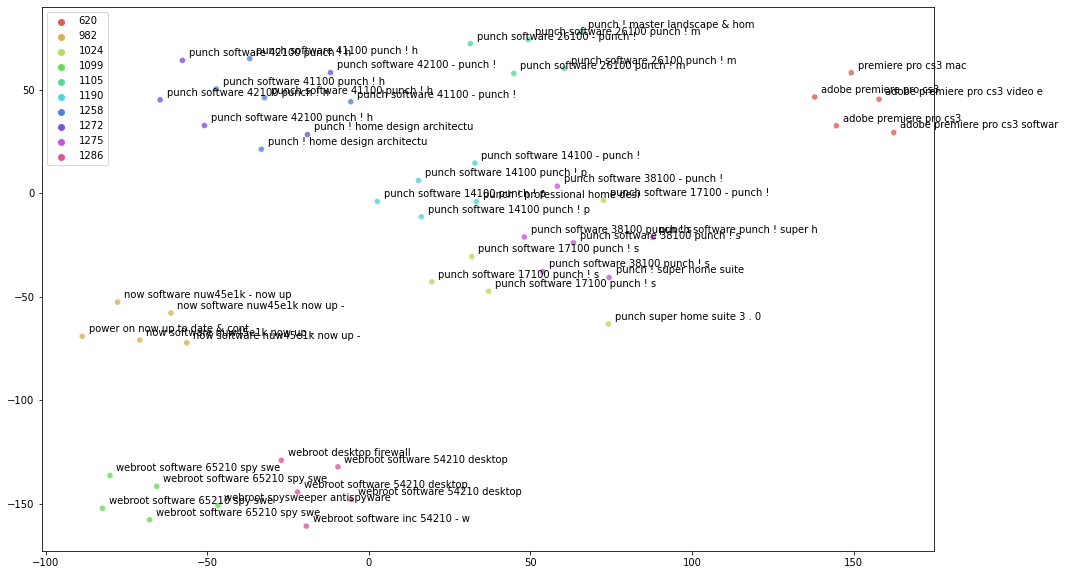

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x=tsne_results[:,0],
    y=tsne_results[:,1],
    hue=vis_y,
    palette=sns.color_palette("hls", len(vis_cluster_dict.keys())),
    legend="full",
    alpha=0.8
)
for id_, (x, y) in zip(itertools.chain.from_iterable(vis_cluster_dict.values()), tsne_results):
    # text = id_
    text = test_row_dict[id_]['name'][:30]
    ax.text(x + 2, y + 2, text)